In [ ]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import rasterio
from rasterio.mask import mask
from rasterio.transform import from_origin
import geopandas as gpd
import cv2
import random



Step 1 : Patch Extraction 

In [ ]:
def extract_patches(image_path, label_path, shapefile_path, output_dir, train_ratio=0.75, val_ratio=0.2, test_ratio=0.05):
    
    with rasterio.open(image_path) as src_img:
        
        with rasterio.open(label_path) as src_lbl:
            
            grid = gpd.read_file(shapefile_path) #Load the satellite image, load the labels, and then the grid containing the patches. 
            
            train_img_dir = os.path.join(output_dir, 'train/images')
            val_img_dir = os.path.join(output_dir, 'validation/images')
            test_img_dir = os.path.join(output_dir, 'test/images')

            train_lbl_dir = os.path.join(output_dir, 'train/labels')
            val_lbl_dir = os.path.join(output_dir, 'validation/labels')
            test_lbl_dir = os.path.join(output_dir, 'test/labels')
            #Create the train, validation, and test directories if they do not already exist.
            
            for dir_path in [train_img_dir, val_img_dir, test_img_dir, train_lbl_dir, val_lbl_dir, test_lbl_dir]:
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)

            
            indices = list(grid.index)
            random.shuffle(indices)
            # Shuffle the patch indices for a random distribution
            
            num_patches = len(indices)
            num_train = int(train_ratio * num_patches)
            num_val = int(val_ratio * num_patches)
            num_test = num_patches - num_train - num_val
            # Calculate the sizes of the train, validation, and test sets.
            
            train_indices = indices[:num_train]
            val_indices = indices[num_train:num_train + num_val]
            test_indices = indices[num_train + num_val:]

            
            def save_patch_and_label(patch, label, transform, output_img_subdir, output_lbl_subdir, patch_filename):
                
                patch_img_path = os.path.join(output_img_subdir, patch_filename)
                with rasterio.open(
                    patch_img_path, 'w',
                    driver='GTiff',
                    height=224, width=224,
                    count=4, dtype=patch.dtype, #Set the count variable according to the number of spectral bands you have.
                    crs=src_img.crs, transform=transform
                ) as dst_img:
                    dst_img.write(patch)
                print(f"Image patch {patch_filename} saved in {output_img_subdir}.")

                
                patch_lbl_path = os.path.join(output_lbl_subdir, patch_filename)
                with rasterio.open(
                    patch_lbl_path, 'w',
                    driver='GTiff',
                    height=224, width=224,
                    count=1, dtype=label.dtype,  # Single channel for labels
                    crs=src_lbl.crs, transform=transform
                ) as dst_lbl:
                    dst_lbl.write(label[0, :, :], 1)  # Correcting the write operation
                print(f"Label patch {patch_filename} saved in {output_lbl_subdir}.")

            
            for idx, row in grid.iterrows():
                geom = [row['geometry']]
                auto_value = row['AUTO']

                # Extract the patch for the image
                patch_img, transform = mask(src_img, geom, crop=True)
                patch_lbl, _ = mask(src_lbl, geom, crop=True)

                # Check the patch size and resize if necessary (for the image and the label)
                height_img, width_img = patch_img.shape[1], patch_img.shape[2]
                height_lbl, width_lbl = patch_lbl.shape[1], patch_lbl.shape[2]
                
                if height_img != 224 or width_img != 224:
                    resized_patch_img = np.zeros((6, 224, 224), dtype=patch_img.dtype)
                    for i in range(6):
                        resized_patch_img[i] = cv2.resize(patch_img[i], (224, 224), interpolation=cv2.INTER_LINEAR)
                    patch_img = resized_patch_img
                
                if height_lbl != 224 or width_lbl != 224:
                    resized_patch_lbl = cv2.resize(patch_lbl[0], (224, 224), interpolation=cv2.INTER_NEAREST)
                    patch_lbl = resized_patch_lbl[np.newaxis, :, :]  # Add channel dimension
                
                # Determine the directory to save the patch
                patch_filename = f"patch_{auto_value}.tif"
                if idx in train_indices:
                    save_patch_and_label(patch_img, patch_lbl, transform, train_img_dir, train_lbl_dir, patch_filename)
                elif idx in val_indices:
                    save_patch_and_label(patch_img, patch_lbl, transform, val_img_dir, val_lbl_dir, patch_filename)
                elif idx in test_indices:
                    save_patch_and_label(patch_img, patch_lbl, transform, test_img_dir, test_lbl_dir, patch_filename)

    print("Patch and label extraction completed, and distribution performed.")

# Utilisation de la fonction
image_path = "path/to/your/Image.tif"
label_path = "path/to/your/Label.tif"
shapefile_path = "path/to/your/Grid.shp"
output_dir = "path/to/your/repo/Patch"
extract_patches(image_path, label_path, shapefile_path, output_dir)

Step 2 : Images pre-processing

In [ ]:
# Normalization
def normalize_img(img):
    return img / np.max(img)

# Function to read .tif files and convert them into tensors
def load_data(image_dir, mask_dir):
    images = []
    masks = []
    for img_file in os.listdir(image_dir):
        if img_file.endswith('.tif') or img_file.endswith('.tiff'):
            img_path = os.path.join(image_dir, img_file)
            mask_path = os.path.join(mask_dir, img_file)
            
            # Read images and masks
            img = tiff.imread(img_path).astype(np.float32)
            mask = tiff.imread(mask_path).astype(np.uint8)
            
            img = normalize_img(img)
            
            images.append(img)
            masks.append(mask)
    
    # Convert the lists into numpy arrays
    images = np.array(images)
    masks = np.array(masks)
    
    # Convert numpy arrays into tensors
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    masks = tf.convert_to_tensor(masks, dtype=tf.uint8)
    
    return images, masks

train_image_dir = '/Patch/train/images'
train_mask_dir = '/Patch/train/labels'
val_image_dir = '/Patch/validation/images/'
val_mask_dir = '/Patch/validation/labels'


# Load and transform the training data
train_images, train_masks = load_data(train_image_dir, train_mask_dir)
val_images, val_masks = load_data(val_image_dir, val_mask_dir)

print(f'Shape of training images: {train_images.shape}')
print(f'Shape of training labels: {train_masks.shape}')

# Check the pixel values of the images
print(f'Minimum and maximum values of the training images: {tf.reduce_min(train_images).numpy()}, {tf.reduce_max(train_images).numpy()}')
print(f'Minimum and maximum values of the training labels: {tf.reduce_min(train_masks).numpy()}, {tf.reduce_max(train_masks).numpy()}')

print(f'Minimum and maximum values of the validation images: {tf.reduce_min(val_images).numpy()}, {tf.reduce_max(val_images).numpy()}')
print(f'Minimum and maximum values of the validation labels: {tf.reduce_min(val_masks).numpy()}, {tf.reduce_max(val_masks).numpy()}')

# Display an RGB image and its corresponding mask
idx = 17  # You can change this index to visualize other images
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(train_images[idx][:, :, :3])  
plt.title('Training image (RGB)')

plt.subplot(1, 2, 2)
plt.imshow(train_masks[idx], cmap='gray') 
plt.title('training label')

plt.show()

Step 3 : Train of the U-Net Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 4)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         2368      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 64)         0         ['batch_normalization[0][0

2024-12-05 14:16:53.920574: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-12-05 14:16:54.298213: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-05 14:16:54.376646: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-05 14:16:54.796788: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-05 14:16:59.301341: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8b59ae49b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-05 14:16:59.301375: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, C

330/330 [==============================] - ETA: 0s - loss: 0.9095 - accuracy: 0.6457
Epoch 1: val_loss improved from inf to 0.75288, saving model to /mnt/c/Users/PC/Bureau/Travail/Thèse_SSD/Unet_RS/Unet4RSImage/Test_2/Model_new.h5


/home/aleguillou/anaconda3/envs/dl/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


330/330 [==============================] - 58s 112ms/step - loss: 0.9095 - accuracy: 0.6457 - val_loss: 0.7529 - val_accuracy: 0.6262
Epoch 2/100
330/330 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.7109
Epoch 2: val_loss improved from 0.75288 to 0.60247, saving model to /mnt/c/Users/PC/Bureau/Travail/Thèse_SSD/Unet_RS/Unet4RSImage/Test_2/Model_new.h5
330/330 [==============================] - 34s 102ms/step - loss: 0.7100 - accuracy: 0.7109 - val_loss: 0.6025 - val_accuracy: 0.7587
Epoch 3/100
330/330 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.7297
Epoch 3: val_loss did not improve from 0.60247
330/330 [==============================] - 32s 95ms/step - loss: 0.6723 - accuracy: 0.7297 - val_loss: 0.6907 - val_accuracy: 0.6718
Epoch 4/100
330/330 [==============================] - ETA: 0s - loss: 0.6568 - accuracy: 0.7360
Epoch 4: val_loss improved from 0.60247 to 0.56372, saving model to /mnt/c/Users/PC/Bureau/Travail/Thèse_SSD/Un

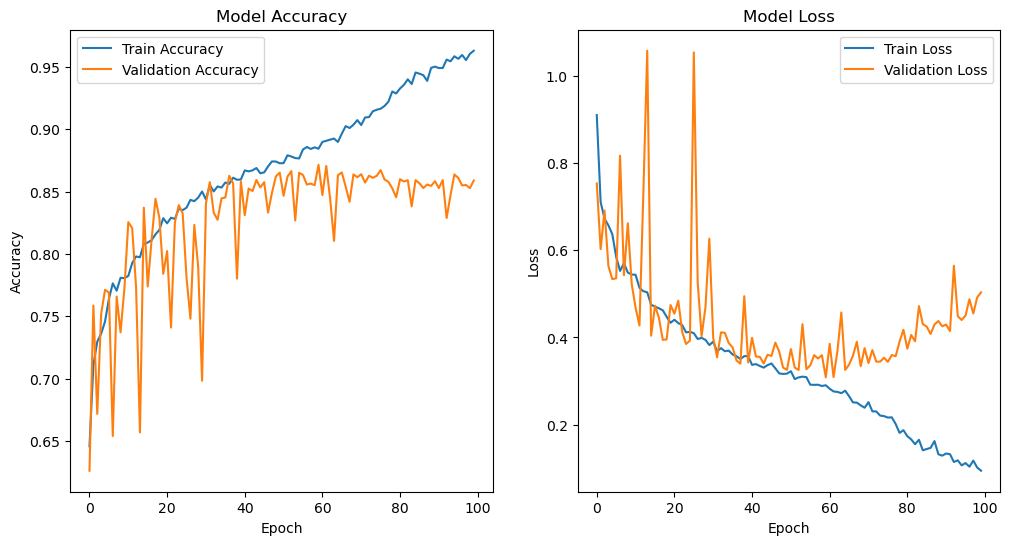

The training is complete, and the best model is saved.


In [ ]:

def unet_advanced(input_shape, num_classes=6):
    inputs = Input(input_shape)
    
    # Encodeur
    conv1 = Conv2D(64, 3, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, 3, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, 3, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)
    
    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, 3, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)
    
    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, 3, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)
    
    conv5 = Conv2D(1024, 3, padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, 3, padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    merge6 = Concatenate()([conv4, up6])
    conv6 = Conv2D(512, 3, padding='same')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, 3, padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Conv2D(256, 3, padding='same')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, 3, padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Conv2D(128, 3, padding='same')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, 3, padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    
    up9 = UpSampling2D(size=(2, 2))(conv8)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Conv2D(64, 3, padding='same')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, 3, padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the parameters
img_height = 224
img_width = 224
num_channels = 4  # Variable to select the number of input channels
num_classes = 6   # Here is the number of classes you need to predict +1
batch_size = 4   # Reduce the batch size to decrease memory usage

# Initialize the U-Net model
input_shape = (img_height, img_width, num_channels)
model = unet_advanced(input_shape, num_classes=num_classes)
model.summary()

# Define the callback to save the best epoch
saved_model_path = "/path/to/your/saved_model"
checkpoint_cb = ModelCheckpoint(
    filepath=saved_model_path,  # Path to save the best model
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_format="tf",  # Ensure SavedModel format
    verbose=1
)

# Train the model with the callback
history = model.fit(
    train_images,
    train_masks,
    batch_size=batch_size,
    epochs=100,
    validation_data=(val_images, val_masks),
    callbacks=[checkpoint_cb]
)

print(f"The best model has been saved in SavedModel format at {saved_model_path}.")

# After training, plot the loss and accuracy graphs
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Save the plot as a PNG file
    plt.savefig('/path/to/your/training_history.png')
    plt.show()

# Call the function to plot and save the training history
plot_training_history(history)

print("Training history plot is saved.")

Step 4 : Displaying results

In [ ]:
# Normalize the image
def normalize_img(img):
    return img / np.max(img)

# Load a test image and keep the geo-referencing information
def load_test_image(image_path):
    img = tiff.imread(image_path).astype(np.float32)
    img = normalize_img(img)
    img = np.expand_dims(img, axis=0)
    
    # Read the geo-referencing info (e.g., transform and CRS)
    with rasterio.open(image_path) as src:
        transform = src.transform
        crs = src.crs
        
    return img, transform, crs

# Load a test label
def load_test_mask(mask_path):
    mask = tiff.imread(mask_path).astype(np.uint8)
    return mask

# Paths to the test image and test label
test_image_path = 'test/images/patch_1.0.tif'  
test_mask_path = 'test/labels/patch_1.0.tif'

# Load the saved model (SavedModel format)
saved_model_path = '/path/to/your/saved_model'  # Path to the directory of the SavedModel
model = tf.keras.models.load_model(saved_model_path)

# Load and prepare the test image and test label
test_image, transform, crs = load_test_image(test_image_path)
test_mask = load_test_mask(test_mask_path)
print(f'Shape of test image: {test_image.shape}')
print(f'Shape of test mask: {test_mask.shape}')

# Predict the segmentation of the test image
prediction = model.predict(test_image)
predicted_mask = tf.argmax(prediction, axis=-1)
predicted_mask = tf.squeeze(predicted_mask).numpy()

# Save the predicted mask with geo-referencing
predicted_mask_path = 'example/predicted_mask.tif'  # Replace with the path where you want to save the predicted mask

# Write the predicted mask using rasterio, preserving the geo-referencing
with rasterio.open(test_image_path) as src:
    meta = src.meta  # Get the metadata (including the transform)
    meta.update(driver='GTiff', dtype=rasterio.uint8, count=1)  # Update the metadata to match the predicted mask's data type and single band count
    
    # Save the predicted mask as a georeferenced TIFF
    with rasterio.open(predicted_mask_path, 'w', **meta) as dst:
        dst.write(predicted_mask, 1)  # Write the predicted mask as the first band

print(f'Predicted mask saved as {predicted_mask_path}')

# Display the test image, the test label, and the predicted mask
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(test_image[0][:, :, :3])  
plt.title('Test Image (RGB)')

plt.subplot(1, 3, 2)
plt.imshow(test_mask, cmap='gray')
plt.title('Test Label')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.show()

